# EM shower reconstruction with the SciFi at SND@LHC

1. __make sure the preprocessing has already been done__

2. __make sure `results` folder exists__


based on https://github.com/pauldebryas/SND_trackers_My_data/tree/SNDatLHC_neutrino

In [1]:
# imports from utils.py & net.py
from utils import DataPreprocess, Parameters
from net import SNDNet, BNN, MyDataset, digitize_signal, digitize_signal_1d

# python
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pylab as plt
import time
from tqdm import tqdm
from IPython import display

# system
import os
import gc  # Gabage collector interface (to debug stuff)
import sys

# ml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# dl
import torch
import torch.nn as nn

# bayesian
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

Welcome to JupyROOT 6.18/00


In [2]:
# Test to see if cuda is available or not + listed the CUDA devices that are available
try:
    assert(torch.cuda.is_available())
except:
    raise Exception("CUDA is not available")
    
n_devices = torch.cuda.device_count()
print("CUDA devices available:")

for i in range(n_devices):
    print("\t{}\twith CUDA capability {}".format(torch.cuda.get_device_name      (device=i), 
                                                 torch.cuda.get_device_capability(device=i)))

device = torch.device("cuda", 0)

CUDA devices available:
	Quadro P2200	with CUDA capability (6, 1)


In [3]:
# Turn off interactive plotting: for long run it screws up everything
plt.ioff()

In [4]:
DETECTOR_PARAMS = Parameters("SNDatLHC")
PATH_CCDIS = "$HOME/snd_data/processed_data/CCDIS"
PATH_NUEEL = "$HOME/snd_data/processed_data/NuEElastic"

# number of planes of the detector
NB_PLANE = len(DETECTOR_PARAMS.snd_params[DETECTOR_PARAMS.configuration]["TT_POSITIONS"])

## Data processing

Here we load and process __pickle__ files. 

In [5]:
def read_chunklist(proc_file_path, step_size, file_size):
    # step_size = size of a chunk
    # file_size = size of the CCDIS BigFile

    n_steps = int(file_size / step_size) # number of chunks

    chunklist_TT_df  = [] # list of the TT_df file of each chunk
    chunklist_y_full = [] # list of the y_full file of each chunk
    
    # first 2 
    for i in range(2):
        outpath = proc_file_path + "/{}".format(i)
        chunklist_TT_df .append(pd.read_pickle(os.path.join(outpath, "tt_cleared.pkl")))
        chunklist_y_full.append(pd.read_pickle(os.path.join(outpath, "y_cleared.pkl")))

    reindex_TT_df  = pd.concat([chunklist_TT_df[0],
                                chunklist_TT_df[1]],  ignore_index=True)
    reindex_y_full = pd.concat([chunklist_y_full[0],
                                chunklist_y_full[1]], ignore_index=True)

    print("Before Reduction (file " + proc_file_path + "):")

    # other n-2
    for i in range(n_steps-2):
        outpath = proc_file_path + "/{}".format(i+2)
        
        # add all the tt_cleared.pkl files read_pickle and add to the chunklist_TT_df list
        chunklist_TT_df.append(pd.read_pickle(os.path.join(outpath, "tt_cleared.pkl")))
        
        # add all the y_cleared.pkl files read_pickle and add to the chunklist_y_full list
        chunklist_y_full.append(pd.read_pickle(os.path.join(outpath, "y_cleared.pkl")))
        
        reindex_TT_df  = pd.concat([reindex_TT_df,  
                                          chunklist_TT_df[i+2]], ignore_index=True)
        reindex_y_full = pd.concat([reindex_y_full, 
                                    chunklist_y_full[i+2]], ignore_index=True)
    
    print("  TT_df  inelastic: " + str(len(reindex_TT_df)))
    print("  y_full inelastic: " + str(len(reindex_y_full)))

    return reindex_TT_df, reindex_y_full

In [6]:
def load_dataframes(params, path_ccdis, path_nueel):
    
    # Here we choose the geometry with 9 time the radiation length
    proc_path_ccdis = os.path.expandvars(path_ccdis)
    proc_path_nueel = os.path.expandvars(path_nueel)
    
    # --- LOAD THE reindex_TT_df & reindex_y_full PD.DATAFRAME ---

    # It is reading and analysing data by chunk instead of all at the time (memory leak problem)
    print("\nReading the tt_cleared.pkl & y_cleared.pkl files by chunk of CCDIS and NueEElastic")
    
    reidx_TT_df  = dict()
    reidx_y_full = dict()
    
    reidx_TT_df['ccdis'], reidx_y_full['ccdis'] = read_chunklist(proc_path_ccdis, 10**3, 400000) # CCDIS
    reidx_TT_df['nueel'], reidx_y_full['nueel'] = read_chunklist(proc_path_nueel, 10**3, 399000) # NueEElastic
    
    return reidx_TT_df, reidx_y_full

In [7]:
def balance_events_num(reindex_TT_df, reindex_y_full):
    # Selecting events to ensure equal number of elastic and inelastic events
    event_limit = min(len(reindex_TT_df['ccdis']),
                      len(reindex_y_full['nueel']))

    for part_type in ['ccdis', 'nueel']:
        remove = int(len(reindex_TT_df[part_type]) - event_limit) + 1
        reindex_TT_df [part_type] = reindex_TT_df [part_type][:-remove]
        reindex_y_full[part_type] = reindex_y_full[part_type][:-remove]
    
    return reindex_TT_df, reindex_y_full

In [8]:
def merge_events_arrays(reindex_TT_df, reindex_y_full):
    # Merging CCDIS and NueEElastic in a single array
    combined_TT_df  = pd.concat([reindex_TT_df ['ccdis'], 
                                 reindex_TT_df ['nueel']], ignore_index=True)
    combined_y_full = pd.concat([reindex_y_full['ccdis'], 
                                 reindex_y_full['nueel']], ignore_index=True)
    
    print("After Reduction  :\n")

    for part_type in ['ccdis', 'nueel']:
        print("Particle type: " + part_type)
        print("  TT_df  inelastic: " + str(len(reindex_TT_df [part_type])))
        print("  y_full inelastic: " + str(len(reindex_y_full[part_type])))

    print()
    print("Combined TT_df : " + str(len(combined_TT_df)))
    print("Combined y_full: " + str(len(combined_y_full)))
    
    return combined_TT_df, combined_y_full

In [9]:
def normalise_target_energy(reindex_y_full):
    # True value of NRJ for each true Nue event
    NORM = 1. / 4000
    reindex_y_full[["E"]] *= NORM
    return reindex_y_full

In [10]:
#reidx_TT_df, reidx_y_full = load_dataframes(DETECTOR_PARAMS, PATH_CCDIS, PATH_NUEEL)

In [11]:
#reidx_TT_df, reidx_y_full = balance_events_num (reidx_TT_df, reidx_y_full)

In [12]:
#merged_TT_df, merged_y_full = merge_events_arrays(reidx_TT_df, reidx_y_full)

In [13]:
#merged_y_full = normalise_target_energy(merged_y_full)

In [14]:
def read_pickled_df(detector_params, path_ccdis, path_nueel):
    reidx_TT_df, reidx_y_full = load_dataframes(detector_params, path_ccdis, path_nueel)
    reidx_TT_df, reidx_y_full = balance_events_num(reidx_TT_df, reidx_y_full)
    merged_TT_df, merged_y_full = merge_events_arrays(reidx_TT_df, reidx_y_full)
    
    merged_y_full = normalise_target_energy(merged_y_full)
    
    return merged_TT_df, merged_y_full

## Data preparation

Here we prepare (load or, if needed, create) the datasets.

In [15]:
SGN_DGT_MODE_NAMES = ['sum', 'longitudal', 'projection', 'plane']
SGN_DGT_MODES = dict(zip(SGN_DGT_MODE_NAMES, 
                         np.arange(len(SGN_DGT_MODE_NAMES))))
# 0d - sum of all vals = 1 number, for baseline
# 1d - (z) = sum for each z, for advanced baseline
# 2d - (x,z)(y,z) variation = projections ala tomography, for release (no ghost hits)
# 3d - (x,y) variation, for conv testing


def make_dataset(pickled_TT_df, pickled_y_df, detector_params,
                 used_data_coef  = 1., 
                 sgn_dgt_mode    = SGN_DGT_MODES['sum']):

    assert len(pickled_TT_df) == len(pickled_y_df)
    assert used_data_coef > 0.
    assert used_data_coef <= 1.

    full_data_size = len(pickled_TT_df)

    # select subset of available data to make debug training faster
    data_size = int(used_data_coef * full_data_size)
    
    # normalised energies array cast to numpy and subset taken
    y_arr = pickled_y_df["E"].to_numpy()[:data_size]

    # create simplistic dataset (sum pixels in (x,y) representation)
    X_arr = []

    nb_of_plane = len(detector_params.snd_params[detector_params.configuration]["TT_POSITIONS"])
    
    for i in tqdm(range(data_size)):
        # xy variation
        
        shower_stat = None

        xy_plane = digitize_signal(pickled_TT_df.iloc[i], detector_params, filters = nb_of_plane)
        
        if   sgn_dgt_mode == SGN_DGT_MODES['plane']:
            shower_stat = xy_plane
        
        elif sgn_dgt_mode == SGN_DGT_MODES['projection']:
            xz = xy_plane.sum(axis=1)
            yz = xy_plane.sum(axis=2)
            
            shower_stat = np.concatenate((xz, yz), axis=1)

        elif sgn_dgt_mode == SGN_DGT_MODES['longitudal']:
            shower_stat = xy_plane.sum(axis=(1,2))

        elif sgn_dgt_mode == SGN_DGT_MODES['sum']:
            shower_stat = xy_plane.sum()
        
        else:
            raise Exception("Unknown signal digitization mode")

        X_arr.append(shower_stat)

    X_arr = np.array(X_arr)

    return X_arr, y_arr

In [16]:
def save_dataset(full_X, full_y, fname):
    with open(fname, 'wb') as file:
        np.savez(file, x=full_X, y=full_y)        
    return

In [19]:
def create_dataset(mode, detector_params, path_ccdis, path_nueel,
                   used_data_coef = 1.0):
    
    merged_TT_df, merged_y_full = read_pickled_df(detector_params, path_ccdis, path_nueel)

    assert mode in SGN_DGT_MODE_NAMES
    print(mode)
        
    dataset_fname = 'dataset_' + mode + '.npz'

    full_X, full_y = make_dataset(merged_TT_df, merged_y_full, DETECTOR_PARAMS,
                                  used_data_coef = used_data_coef,
                                  sgn_dgt_mode = SGN_DGT_MODES[mode])

    save_dataset(full_X, full_y, dataset_fname)
        
    return

In [20]:
# create_dataset('sum', DETECTOR_PARAMS, PATH_CCDIS, PATH_NUEEL)

In [21]:
# create_dataset('longitudal', DETECTOR_PARAMS, PATH_CCDIS, PATH_NUEEL)

In [22]:
# create_dataset('projection', DETECTOR_PARAMS, PATH_CCDIS, PATH_NUEEL)

In [44]:
# memory troubles!
# create_dataset('plane', DETECTOR_PARAMS, PATH_CCDIS, PATH_NUEEL)

In [25]:
def load_dataset(mode='sum'):
    assert mode in SGN_DGT_MODE_NAMES
    
    dataset_fname = 'dataset_' + mode + '.npz'

    full_X, full_y = None, None

    if os.path.isfile(dataset_fname) == False:
        create_dataset(mode, DETECTOR_PARAMS, PATH_CCDIS, PATH_NUEEL)

    else:    
        # load if exists
        full_dts = None

        with open(dataset_fname, 'rb') as file:
            full_dts = np.load(file)#, allow_pickle=True)
            
            full_X = full_dts['x']
            full_y = full_dts['y']
        
    return full_X, full_y

In [26]:
full_X, full_y = load_dataset('sum')

In [27]:
data_size = full_X.shape[0]

# Train test split
TRAIN_SIZE_RATIO = 0.9
RANDOM_SEED = 1543

all_idx = np.arange(0, data_size)

train_idx, test_idx, _, _ = train_test_split(all_idx, all_idx, 
                                             train_size=TRAIN_SIZE_RATIO, 
                                             random_state=RANDOM_SEED)

train_size = len(train_idx)
test_size  = len(test_idx)

In [28]:
full_X = full_X.reshape(-1, 1)
full_y = full_y.reshape(-1, 1)

In [29]:
X_train = full_X[train_idx]
y_train = full_y[train_idx]

X_test = full_X[test_idx]
y_test = full_y[test_idx]

## Linear regression baseline

### Train

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [31]:
reg_l2 = LinearRegression()   .fit(X_train, y_train) # positive=True ???
reg_l1 = Lasso(positive=False).fit(X_train, y_train) # positive=True ???

score_l2 = reg_l2.score(X_train, y_train)
score_l1 = reg_l1.score(X_train, y_train)

print('L2: ', score_l2)
print('L1: ', score_l1)

y_pred_l2 = reg_l2.predict(X_train)
y_pred_l1 = reg_l1.predict(X_train)

L2:  0.061602172943386775
L1:  0.06159146316771591


In [32]:
# in this variation we cut off data with low number of nonzero pixels
# since, as we see below, true energy for those examples can have any value

CLIP_PERC = 30
min_clip = np.percentile(X_train, CLIP_PERC)
print(str(CLIP_PERC) + ' percentile min clip ', min_clip)

clip_idx = np.where(X_train > min_clip)

X_train_clip = X_train[clip_idx].reshape(-1, 1)
y_train_clip = y_train[clip_idx].reshape(-1, 1)

reg_l2.fit(X_train_clip, y_train_clip)
reg_l1.fit(X_train_clip, y_train_clip)

y_pred_l2_clip = reg_l2.predict(X_train_clip)
y_pred_l1_clip = reg_l1.predict(X_train_clip)

30 percentile min clip  158.0


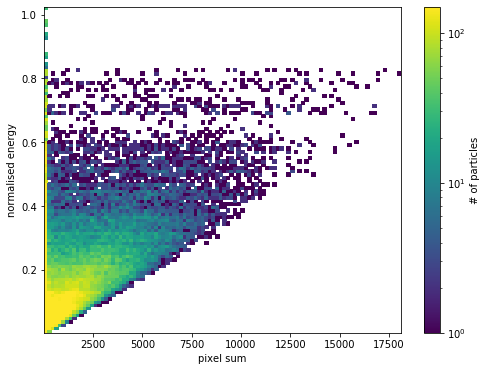

In [33]:
fig, ax = plt.subplots(figsize=(8,6))

hist = ax.hist2d(full_X[:, 0], full_y[:, 0], 
                 bins=100, 
                 norm=mpl.colors.LogNorm(), 
                 vmax=150)

plt.xlabel('pixel sum')
plt.ylabel('normalised energy')

cbar = fig.colorbar(hist[3], ax=ax)
cbar.set_label('# of particles')

plt.show()

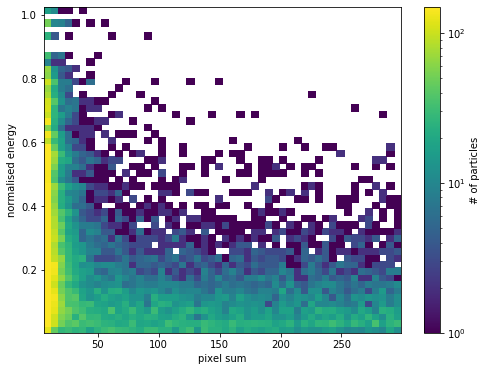

In [34]:
fig, ax = plt.subplots(figsize=(8,6))

idx = np.where(full_X < 300)

hist = ax.hist2d(full_X[idx], 
                 full_y[idx], 
                 bins=(50,50), 
                 norm=mpl.colors.LogNorm(), 
                 vmax=150)

plt.xlabel('pixel sum')
plt.ylabel('normalised energy')

cbar = fig.colorbar(hist[3], ax=ax)
cbar.set_label('# of particles')

plt.show()

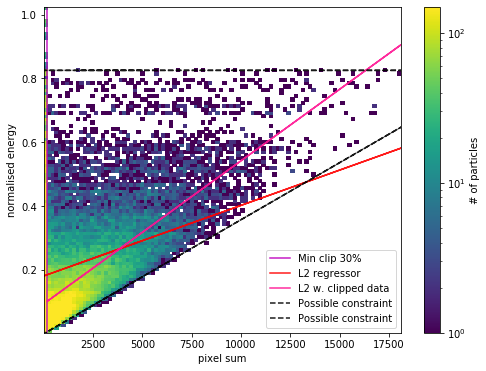

In [35]:
fig, ax = plt.subplots(figsize=(8,6))

hist = ax.hist2d(X_train[:, 0], y_train[:, 0], 
                 bins=100,
                 norm=mpl.colors.LogNorm(), 
                 vmax=150)
plt.xlabel('pixel sum')
plt.ylabel('normalised energy')

plt.axvline(x=min_clip, c='m', alpha=0.9, label='Min clip ' + str(CLIP_PERC) + '%')

#ax.plot(X_train, y_pred_l1, 'w', alpha=0.9, label='L1 regressor')
ax.plot(X_train, y_pred_l2, 'r', alpha=0.9, label='L2 regressor')
#ax.plot(X_train_clip, y_pred_l1_clip, 'w', alpha=0.9, label='L1 clip')
ax.plot(X_train_clip, y_pred_l2_clip, 'deeppink', alpha=0.9, label='L2 w. clipped data')

ax.plot(X_train, X_train / 28000., '--', c='black', alpha=0.9, label='Possible constraint')
ax.plot(X_train, np.full(X_train.shape, 0.825), '--', c='black', alpha=0.9, label='Possible constraint')

cbar = fig.colorbar(hist[3], ax=ax)
cbar.set_label('# of particles')

plt.legend(loc='lower right')
plt.show()

Pixel sums in (x,y) representation



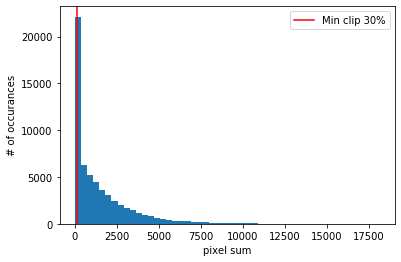

In [36]:
#clip_size = np.where(X_train <= min_clip)[0].shape[0]
#print('Cuts', clip_size / train_size * 100., '% of the dataset')

print("Pixel sums in (x,y) representation\n")
plt.hist(X_train, bins=50)

plt.axvline(x=min_clip, c='r', label='Min clip ' + str(CLIP_PERC) + '%')

plt.xlabel('pixel sum')
plt.ylabel('# of occurances')
plt.legend()
plt.show()

Normalised true energies



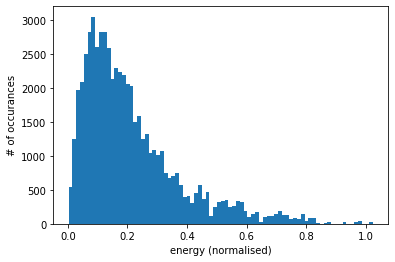

In [37]:
print("Normalised true energies\n")
plt.hist(y_train, bins=80)
plt.xlabel('energy (normalised)')
plt.ylabel('# of occurances')
plt.show()

Pixel sums in (x,y) representation



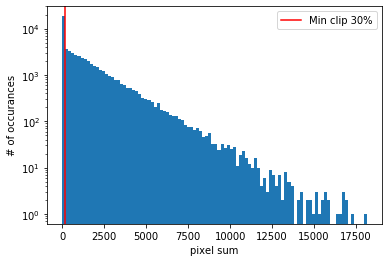

In [38]:
print("Pixel sums in (x,y) representation\n")
plt.hist(X_train, bins=100, log=True)

plt.axvline(x=min_clip, c='r', label='Min clip ' + str(CLIP_PERC) + '%')

plt.xlabel('pixel sum')
plt.ylabel('# of occurances')
plt.legend()
plt.show()

Normalised true energies



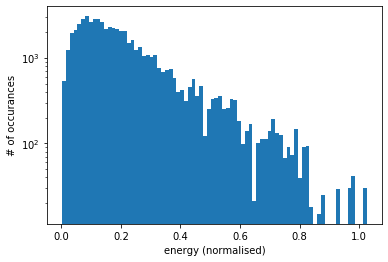

In [39]:
print("Normalised true energies\n")
plt.hist(y_train, bins=80, log=True)
plt.xlabel('energy (normalised)')
plt.ylabel('# of occurances')
plt.show()

### Test

In [40]:
y_pred_l2 = reg_l2.predict(X_test)

delta = y_pred_l2 - y_test
rel_delta = np.divide(delta, y_test)

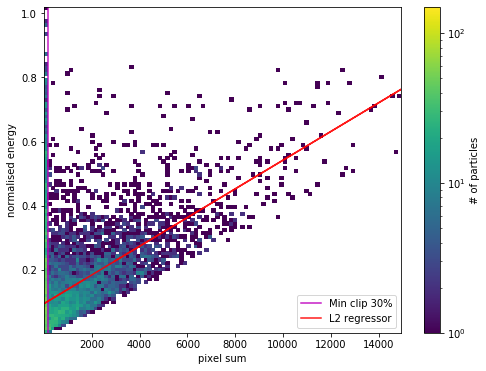

In [41]:
fig, ax = plt.subplots(figsize=(8,6))

hist = ax.hist2d(X_test[:, 0], y_test[:, 0], 
                 bins=100,
                 norm=mpl.colors.LogNorm(), 
                 vmax=150)
plt.xlabel('pixel sum')
plt.ylabel('normalised energy')

plt.axvline(x=min_clip, c='m', alpha=0.9, label='Min clip ' + str(CLIP_PERC) + '%')

ax.plot(X_test, y_pred_l2, 'r', alpha=0.9, label='L2 regressor')

cbar = fig.colorbar(hist[3], ax=ax)
cbar.set_label('# of particles')

plt.legend(loc='lower right')
plt.show()

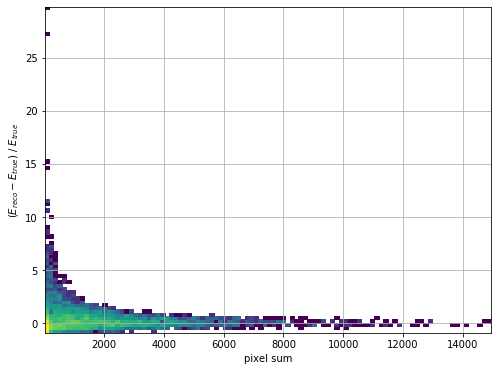

In [42]:
fig, ax = plt.subplots(figsize=(8,6))

hist = ax.hist2d(X_test[:, 0], rel_delta[:, 0], 
                 bins=100,
                 norm=mpl.colors.LogNorm(), 
                 vmax=150)

plt.xlabel('pixel sum')
plt.ylabel(r'$(E_{reco} - E_{true})~/~E_{true}$')
plt.grid()
plt.show()

In [43]:
print('Mean delta after the cut', rel_delta[np.where(X_test > min_clip)[0]].mean())

Mean delta after the cut 0.3800802837325974
